<a href="https://colab.research.google.com/github/JohnLins/ContextCaptions/blob/main/UCSBNLPLABRESEARCH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dependencies: NLTK (Name entity recognition)
BLIP: Raw image captions
BERT

In [ ]:
import nltk
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
from nltk import word_tokenize, pos_tag, ne_chunk


#I WILL USE THIS LATER

sentence = "John Smith walked to California and bought a house in San Francisco"
tokens = word_tokenize(sentence)
pos_tags = pos_tag(tokens)
ner_result = ne_chunk(pos_tags)

print(ner_result)

(S
  (PERSON John/NNP)
  (PERSON Smith/NNP)
  walked/VBD
  to/TO
  (GPE California/NNP)
  and/CC
  bought/VBD
  a/DT
  house/NN
  in/IN
  (GPE San/NNP)
  Francisco/NNP)


Word Vectors:


In [ ]:
import spacy

nlp = spacy.load("en_core_web_sm")


word_vector = nlp("apple").vector
print(word_vector)


[-1.2599487  -0.87038326 -1.0834986   0.5798379   0.03857595 -0.02588724
  0.9775548   0.31093895  0.19412561 -0.8062178   0.43808204 -1.8498268
 -0.30574286  0.5693637   0.42844394  0.69174224 -0.7197368  -1.2614795
  0.83457553  0.14667332  0.12171662  0.48029226  0.50147873 -0.4299112
  0.5533447   0.8749714   0.71914     0.5731143  -0.5064311   0.38493997
 -0.31778833  0.18084693  0.5162936  -0.00233826  0.1870515  -1.3773322
  1.009095   -0.10771251  1.6994228   0.78603184 -0.8166558   0.57896584
 -0.5232718   0.7045958  -0.46308953 -0.37629813 -0.38788998  0.1730735
 -0.05550597 -0.17245518  0.62919456  0.87473     0.60047954 -0.27686393
  0.8524152  -0.28676936  0.9972549  -0.71060055  0.11830124 -0.37214422
 -1.3039289  -0.02281845  0.4063236  -0.43118405  0.9401908  -0.02761412
 -0.39026427 -0.29733896  0.78710043 -0.34422576  0.11906591  0.8003473
  1.4978364  -0.38792044 -0.5264353  -0.38889915 -0.28553864 -0.22295064
  0.8420893  -0.79365766 -0.0956156  -0.96640915 -1.16658

Construct a cross attention matrix

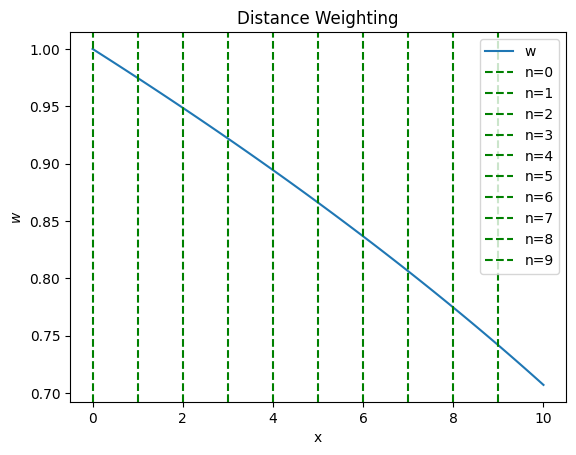

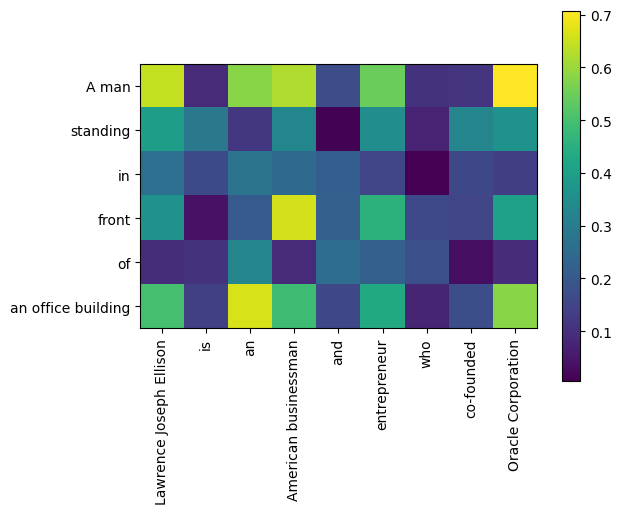

8  
0  
2  
3  
2  
2  


In [ ]:


def to_embeddings(words):
  embeddings = []
  for s in words:
    embedding = [0] * 96
    for w in s.split():
      embedding += nlp(w).vector

    embeddings.append(embedding/len(s.split()))

  return embeddings

def emb_similarity(A, B):
  return np.dot(A, B) / (np.linalg.norm(A) * np.linalg.norm(B))

def similarity(wordA, wordB):
  A = nlp(wordA).vector
  B = nlp(wordB).vector
  return emb_similarity(A, B)

def distance_scale(matrix, center):
  if center > len(matrix[0]):
    print("Center is too big", len(matrix[0]))

  for x in range(center,len(matrix[0])):
    for y in range(len(matrix)):
      matrix[y][x] *= np.sqrt(-x+len(matrix[0]))/np.sqrt(len(matrix[0]))

  for x in range(center,0, -1):
    for y in range(len(matrix)):
      matrix[y][x] *= np.sqrt((x-center)+center)/np.sqrt(center)

  return matrix



n=20
x = np.linspace(0, 10, 100)
y = np.sqrt(-x+n)/np.sqrt(n)

plt.plot(x, y, label="w")
plt.axvline(x=0, color='green', linestyle='--', label='n=0')
plt.axvline(x=1, color='green', linestyle='--', label='n=1')
plt.axvline(x=2, color='green', linestyle='--', label='n=2')
plt.axvline(x=3, color='green', linestyle='--', label='n=3')
plt.axvline(x=4, color='green', linestyle='--', label='n=4')
plt.axvline(x=5, color='green', linestyle='--', label='n=5')
plt.axvline(x=6, color='green', linestyle='--', label='n=6')
plt.axvline(x=7, color='green', linestyle='--', label='n=7')
plt.axvline(x=8, color='green', linestyle='--', label='n=8')
plt.axvline(x=9, color='green', linestyle='--', label='n=9')

plt.xlabel('x')
plt.ylabel(r'$w$')
plt.title('Distance Weighting')
plt.legend()
plt.show()



def get_attention(original_caption, context, graph, pos_scale=-1):
  original_caption_emb = to_embeddings(original_caption)
  context_emb = to_embeddings(context)

  cross_attention_matrix = []

  for o in original_caption_emb:
    temp_row = []
    for c in context_emb:
      temp_row.append(emb_similarity(o,c))
    cross_attention_matrix.append(temp_row)

  cross_attention_matrix = np.array(cross_attention_matrix)
  if pos_scale != -1 :
    cross_attention_matrix = distance_scale(cross_attention_matrix, pos_scale)



  if graph:

    if(len(context) < 30):
      plt.imshow(cross_attention_matrix, cmap='viridis', interpolation='none')
      plt.xticks(np.arange(len(context)), context, rotation='vertical')
      plt.colorbar()
    else:
      plt.figure(figsize=(30, 25))
      plt.imshow(cross_attention_matrix, cmap='viridis', interpolation='none', aspect=3)
      plt.axis("off")
    plt.yticks(np.arange(len(original_caption)), original_caption)
    plt.show()

  return cross_attention_matrix



matrix0 = get_attention(["A man", "standing", "in", "front", "of", "an office building"],
 ["Lawrence Joseph Ellison", "is", "an", "American businessman", "and", "entrepreneur", "who", "co-founded", "Oracle Corporation"], True)


for j in range(len(matrix0)):
  max_attention_score = matrix0[j][0]
  max_attention_index = 0;
  for i in range(len(matrix0[0])):
    if matrix0[j][i] > max_attention_score:
      max_attention_score = matrix0[j][i]
      max_attention_index = i
  print(max_attention_index, " ")


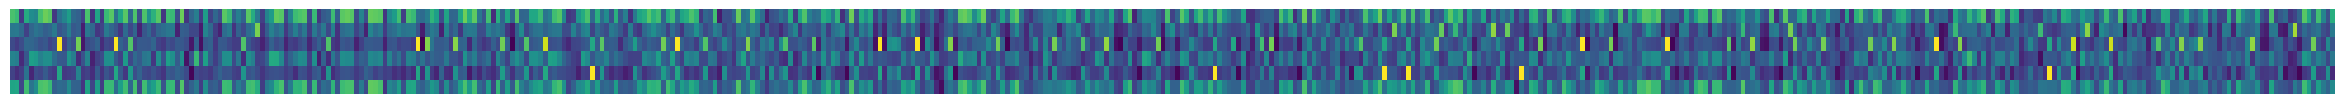

A man  :  name  
standing  :  moving  
in  :  in  
front  :  rival  
of  :  of  
an office building  :  supply  


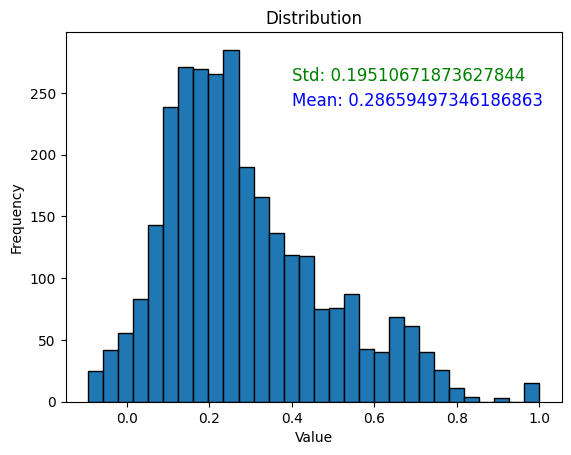

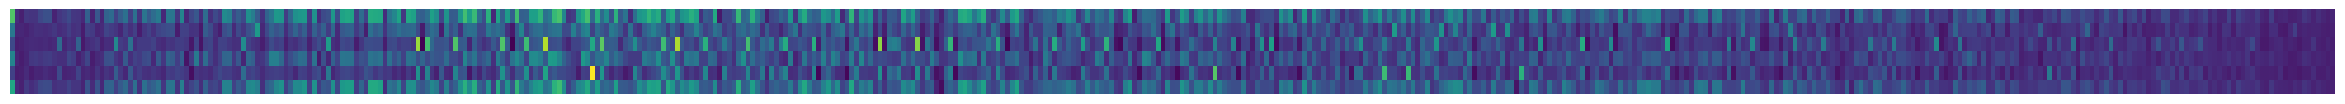

A man  :  Oracle  
standing  :  holding  
in  :  on  
front  :  relational  
of  :  of  
an office building  :  management  


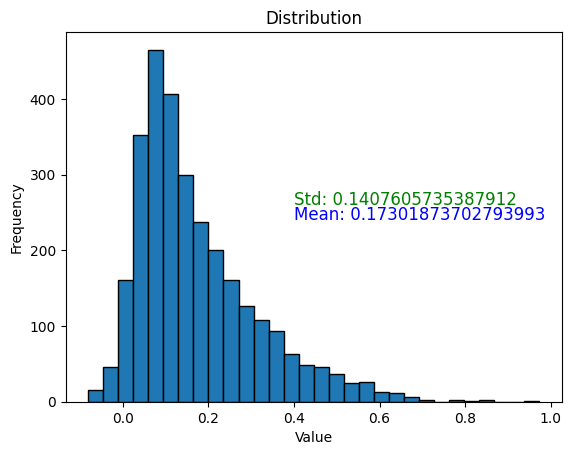

MEAN:  0.17301873702793993
STD:  0.1407605735387912


In [ ]:
context = """Oracle Corporation is an American multinational computer technology company headquartered in Austin, United States. In 2020, Oracle was the third-largest software company in the world by revenue and market capitalization. The company sells database software and technology (particularly its own brands), cloud engineered systems, and enterprise software products, such as enterprise resource planning (ERP) software, human capital management (HCM) software, customer relationship management (CRM) software (also known as customer experience), enterprise performance management (EPM) software, and supply chain management (SCM) software.


Larry Ellison co-founded Oracle Corporation in 1977 with Bob Miner and Ed Oates under the name Software Development Laboratories (SDL). Ellison took inspiration from the 1970 paper written by Edgar F. Codd on relational database management systems (RDBMS) named "A Relational Model of Data for Large Shared Data Banks." He heard about the IBM System R database from an article in the IBM Research Journal provided by Oates. Ellison wanted to make Oracle's product compatible with System R, but failed to do so as IBM kept the error codes for their DBMS a secret. SDL changed its name to Relational Software, Inc (RSI) in 1979, then again to Oracle Systems Corporation in 1983, to align itself more closely with its flagship product Oracle Database. The name also drew from the 1977 CIA project codename, which was also Oracle's first customer. At this stage, Bob Miner served as the company's senior programmer. On March 12, 1986, the company had its initial public offering.

In 1989, Oracle moved its world headquarters to the Redwood Shores neighborhood of Redwood City, California, though its campus was not completed until 1995.

In 1995, Oracle Systems Corporation changed its name to Oracle Corporation, officially named Oracle, but is sometimes referred to as Oracle Corporation, the name of the holding company. Part of Oracle Corporation's early success arose from using the C programming language to implement its products. This eased porting to different operating systems most of which support C.

In 2005, Oracle acquired PeopleSoft, an ERP company, and in 2006 Siebel, a CRM company. In 2008 Oracle acquired BEA Systems, an enterprise infrastructure software company and in 2010 it acquired Sun Microsystems, a computer hardware and software company (famous for its Java programming language).

On July 15, 2013, Oracle transferred its stock listing from the Nasdaq to the NYSE. At the time, it was the largest-ever U.S. market transfer.

In an effort to compete with Amazon Web Services and its products, Oracle announced in 2019 it was partnering with former rival Microsoft. The alliance called that Oracle Cloud and Microsoft Azure would be directly connected, allowing customers of each to store data on both cloud computing platforms and run software on either Oracle or Azure. Some saw this not only as an attempt to compete with Amazon but also with Google and Salesforce, which acquired Looker and Tableau Software, respectively.

On December 11, 2020, Oracle announced that it was moving its world headquarters from Redwood Shores to Austin""".split()


og = ["A man", "standing", "in", "front", "of", "an office building"]

matrix1 = get_attention(og, context, True, pos_scale=-1)


#Get the closest word
for j in range(len(matrix1)):
  max_attention_score = matrix1[j][0]
  max_attention_index = 0;
  for i in range(len(matrix1[j])):
    if matrix1[j][i] > max_attention_score:
      max_attention_score = matrix1[j][i]
      max_attention_index = i
  print(og[j], " : ", context[max_attention_index], " ")


plt.hist(matrix1.flatten(), bins=30, edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution')

plt.text(.4, 240, 'Mean: ' + str(np.mean(matrix1.flatten())), color='blue', fontsize=12)
plt.text(.4, 260,  'Std: '+str(np.std(matrix1.flatten())), color='green', fontsize=12)
plt.show()



matrix2 = get_attention(["A man", "standing", "in", "front", "of", "an office building"], context, True, pos_scale=130)


for j in range(len(matrix2)):
  max_attention_score = matrix2[j][0]
  max_attention_index = 0;
  for i in range(len(matrix2[j])):
    if matrix2[j][i] > max_attention_score:
      max_attention_score = matrix2[j][i]
      max_attention_index = i
  print(og[j], " : ", context[max_attention_index], " ")



plt.hist(matrix2.flatten(), bins=30, edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution')

plt.text(.4, 240, 'Mean: ' + str(np.mean(matrix2.flatten())), color='blue', fontsize=12)
plt.text(.4, 260,  'Std: '+str(np.std(matrix2.flatten())), color='green', fontsize=12)
plt.show()
print("MEAN: ", np.mean(matrix2.flatten()))
print("STD: ", np.std(matrix2.flatten()))